# Trajectory Optimization (TO)

In this notebook, we discuss an efficient numerical method for finding a dynamically feasible trajectory. Let us consider the discrete time optimal control problem (OCP):

$$
\begin{aligned}
    \min_{x_{0:N},\,u_{0:N-1}} &\sum_{k=0}^{N-1} \ell_k(x_k, u_k) + \ell_N(x_N) \\
    \textrm{s.t.} \quad &x_{k+1} = f(x_k, u_k) \\    
    & x_k \in \mathcal{X}_k,\; u_k \in \mathcal{U}_k.
\end{aligned}
$$

In many applications, the systems are given in continuous time, in form of differential equations:
$
\dot{x} = f_\text{c}(x, u).
$
As a result, we need to solve the differential equation via numerical integration. In this notebook, we use the 4th-order explicit Runge–Kutta (RK4) method for integration, without delving into the specifics. For further details, readers are encouraged to refer to Chapter 8 of Rawlings's book. Additionally, for simplicity, we consider an unconstrained numerical OCP. Let us start to solve this problem. First, we treat the system dynamics as equality constraints and formulate the OCP as a nonlinear program
$$
\begin{aligned}
    \min_{\boldsymbol{z}}\; &f(\boldsymbol{z}) \\
    \text{s.t.}\; &h(\boldsymbol{z}) = 0,
\end{aligned}
$$
where $\boldsymbol{z} := \left( x_0, u_0, x_1, u_1, \dots, u_{N-1}, x_N \right)$ represents the concatenated state trajectory and input sequence, and $h(\boldsymbol{z})$ involves the stacked dynamics equations
$$
h(\boldsymbol{z}) = \begin{bmatrix}
x_0 - \hat{x} \\
f(x_0, u_0) - x_1 \\
f(x_1, u_1) - x_2 \\
\vdots \\
f(x_{N-1}, u_{N-1}) - x_N
\end{bmatrix},
$$
where $\hat{x}$ is the initial state. 

## CasADi
We now employ [CasADi](https://web.casadi.org/) to formulate the nonlinear program and solve the optimization problem using [IPOPT](http://cepac.cheme.cmu.edu/pasilectures/biegler/ipopt.pdf). 

In [1]:
import casadi as ca
import numpy as np

dim_x = 4
dim_u = 1

q = ca.SX.sym('q', dim_x)
u = ca.SX.sym('u', dim_u)

# Define the cartpole continuous-time dynamics
q1, q2, q3, q4 = ca.vertsplit(q, 1)

# Parameters
L=1.0 
m1=1.0 
m2=1.0 
g=9.81

q1_dot = q3
q2_dot = q4
q3_dot =  (L*m2*ca.sin(q2)*q4*q4 + u + m2*g*ca.cos(q2)*ca.sin(q2)) / (m1 + m2*(1-ca.cos(q2)**2))
q4_dot = -(L*m2*ca.cos(q2)*ca.sin(q2)*q4*q4 + u*ca.cos(q2) + (m1+m2)*g*ca.sin(q2)) / (L*m1 + L*m2*(1-ca.cos(q2)**2))

q_dot = ca.vertcat(q1_dot, q2_dot, q3_dot, q4_dot)
fc_cartpole = ca.Function('fc_cartpole', [q, u], [q_dot])

# RK4 integration
dt = 0.05
k1 = fc_cartpole(q, u)
k2 = fc_cartpole(q + dt/2*k1, u)
k3 = fc_cartpole(q + dt/2*k2, u)
k4 = fc_cartpole(q + dt*k3, u)
q_next = q + dt/6*(k1 + 2*k2 + 2*k3 + k4)
f_rk4_cartpole = ca.Function('f_rk4_cartpole', [q, u], [q_next])

In [2]:
def solve_TO_ca(x0, N, dt, x_ref, u_ref):
    # Cost weights
    Q = np.diag([1, 20, 1, 1])
    R = np.array([[0.25]])
    Qf = 20 * Q
    
    # Define the state and control decision variables
    X = ca.SX.sym('x', dim_x, N + 1)
    U = ca.SX.sym('u', dim_u, N)
        
    # Quadratic cost function
    cost = 0.
    for k in range(N):
        x_err = X[:,k] - x_ref
        u_err = U[:,k] - u_ref 
        cost += ca.mtimes([x_err.T, Q, x_err]) + ca.mtimes([u_err.T, R, u_err])
    # Terminal cost
    x_err = X[:,-1] - x_ref
    cost += ca.mtimes([x_err.T, Qf, x_err])
    
    # Dynamics constraints
    g_dyn = [X[:,0] - x0]
    # RK4 integration
    for k in range(N):
        x_k = X[:,k]
        u_k = U[:,k]
        # RK4 step
        # k1 = fc_cartpole(x_k, u_k)
        # k2 = fc_cartpole(x_k + dt / 2 * k1, u_k)
        # k3 = fc_cartpole(x_k + dt / 2 * k2, u_k)
        # k4 = fc_cartpole(x_k + dt * k3, u_k)
        # x_next = x_k + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        x_next = f_rk4_cartpole(x_k, u_k)
        g_dyn.append(x_next - X[:,k+1])
        
    # Concatenate constraints
    g = ca.vertcat(*g_dyn)
    g_min = 0.
    g_max = 0.
    
    # Stack up the decision variables
    w = ca.vertcat(ca.reshape(X, -1, 1), ca.reshape(U, -1, 1))
    # Here, you can set bounds on states and controls if necessary
    # For simplicity, we assume no bounds (can be modified as needed)
    w_min = -ca.inf
    w_max =  ca.inf
    
    # Create the NLP problem
    nlp = {'x': w, 'f': cost, 'g': g}
    # Create the solver instance
    solver = ca.nlpsol('solver', 'ipopt', nlp, 
                       {'ipopt': {'print_level': 5}} # Specify the solver options 
    ) 
    
    X_init = np.zeros((dim_x, N + 1))
    U_init = np.zeros((dim_u, N))
    w_init = ca.vertcat(X_init.reshape((-1, 1)), U_init.reshape((-1, 1)))
    
    # Solve the NLP
    solution = solver(x0=w_init, lbx=w_min, ubx=w_max, lbg=g_min, ubg=g_max)
    
    # Extract the solution
    w_opt = solution['x']
    X_opt = w_opt[:dim_x * (N + 1)].reshape((dim_x, N + 1)).full()
    U_opt = w_opt[dim_x * (N + 1):].reshape((dim_u, N)).full()
    
    return X_opt, U_opt

In [3]:
N = 100
dt = 0.05
x_ref = np.array([0, np.pi, 0, 0])
u_ref = np.array([0])
x0 = np.array([0, 0, 0, 0])

X_opt_ca, U_opt_ca = solve_TO_ca(x0, N, dt, x_ref, u_ref)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      804

Total number of variables............................:      504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      404
Total number of inequality c

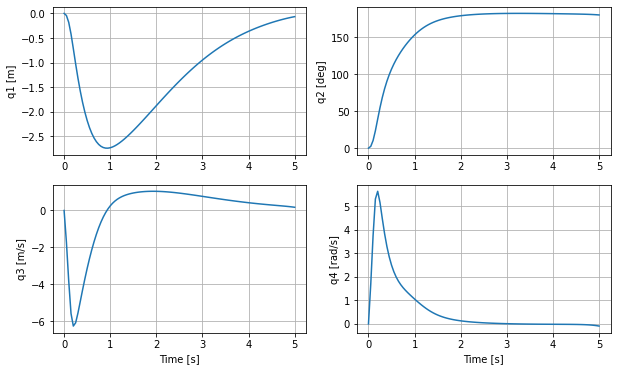

In [4]:
# %matplotlib ipympl
import matplotlib.pyplot as plt

time = np.arange(N + 1) * dt

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(time, X_opt_ca[0,:])
axs[0, 0].set(ylabel='q1 [m]')
axs[0, 0].grid()

axs[0, 1].plot(time, np.rad2deg(X_opt_ca[1,:]))
axs[0, 1].set(ylabel='q2 [deg]')
axs[0, 1].grid()

axs[1, 0].plot(time, X_opt_ca[2,:])
axs[1, 0].set(xlabel='Time [s]', ylabel='q3 [m/s]')
axs[1, 0].grid()

axs[1, 1].plot(time, X_opt_ca[3,:])
axs[1, 1].set(xlabel='Time [s]', ylabel='q4 [rad/s]')
axs[1, 1].grid()

plt.show()

## Iterative LQR (iLQR)

We have solved the TO problem with the help of CasADi. Next, we develop our own TO solver from the perspective of optimization. We begin by writing down the Lagrangian function
$$
\begin{aligned}
    \mathcal{L}(\boldsymbol{z}, \boldsymbol{\lambda}) &= \lambda_0^\top (\hat{x}_0 - x_0) + 
    \sum_{k=0}^{N-1} \left( \ell_k(x_k, u_{k}) + \lambda_{k+1}^\top \left(f(x_{k}, u_{k}) - x_{k+1} \right)\right) + \ell_N(x_N),
\end{aligned}
$$
where $\boldsymbol{\lambda} := (\lambda_0, \dots, \lambda_N)$ is a collection of Lagrange multipliers associated with dynamics constraints.
The first-order optimality condition is given by
$$
\frac{\partial\mathcal{L}}{\partial x_{0:N}} = 0, \quad \frac{\partial\mathcal{L}}{\partial u_{0:N-1}} = 0, \quad  \frac{\partial\mathcal{L}}{\partial \lambda_{0:N}} = 0.
$$

For notational simplicity, we denote stage cost gradients $\nabla_x \ell_k$ and $\nabla_u \ell_k$ as $\ell_{x, k}$ and $\ell_{u, k}$, respectively. The Jacobian matrices of the dynamics are represented by $f_{x, k}$ and $f_{u, k}$.
Let us delve into the optimality condition.

For $k = 0$, we have
$$
\begin{aligned}
    0 &= \ell_{x, 0} + f_{x, 0}^\top \lambda_{1} - \lambda_{0}, \\
    0 &= \ell_{u, 0} + f_{u, 0}^\top \lambda_{1}, \\
    0 &= \hat{x}_0 - x_{0}.
\end{aligned}
$$

For $0 < k <= N-1$, we have
$$
\begin{aligned}
    0 &= \ell_{x, k} + f_{x, k}^\top \lambda_{k+1} - \lambda_{k}, \\
    0 &= \ell_{u, k} + f_{u, k}^\top \lambda_{k+1}, \\
    0 &= f(x_{k-1}, u_{k-1}) - x_{k}.
\end{aligned}
$$

For $k = N$, we have
$$
\begin{aligned}
0 &= \ell_{x, N} - \lambda_{N}, \\
0 &= f(x_{N-1}, u_{N-1}) - x_{N}.
\end{aligned}
$$

Collecting all equations, we obtain
$$
F(\boldsymbol{z}, \boldsymbol{\lambda}) = 
\begin{bmatrix}
    \ell_{x, 0} + f_{x, 0}^\top \lambda_{1} - \lambda_{0} \\
    \ell_{u, 0} + f_{u, 0}^\top \lambda_{1} \\
    \hat{x}_0 - x_{0} \\
    \ell_{x, 1} + f_{x, 1}^\top \lambda_{2} - \lambda_{1} \\
    \ell_{u, 1} + f_{u, 1}^\top \lambda_{2} \\
    f(x_{0}, u_{0}) - x_{1} \\
    \vdots \\
    \ell_{x, N} - \lambda_{N} \\
    f(x_{N-1}, u_{N-1}) - x_{N}
\end{bmatrix} = 0
$$

This becomes a root-finding problem. We apply a Newton-type method to solve it. Each iteration involves solving the folowing linear system
$$
\begin{aligned}
    F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) + \nabla_{\boldsymbol{z}} F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) \delta \boldsymbol{z} + 
    \nabla_{\boldsymbol{\lambda}} F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) (\boldsymbol{\lambda} - \bar{\boldsymbol{\lambda}}) &= 0 \\
    \nabla_{\boldsymbol{z}} F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) \delta \boldsymbol{z} + 
    \nabla_{\boldsymbol{\lambda}} F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) \boldsymbol{\lambda}
    &= -F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) + 
    \nabla_{\boldsymbol{\lambda}} F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) \bar{\boldsymbol{\lambda}},
\end{aligned}
$$
where $\delta \boldsymbol{z} = \boldsymbol{z} - \bar{\boldsymbol{z}}$, with $\bar{\boldsymbol{z}}$ and $\bar{\boldsymbol{\lambda}}$ representing the nominal variables around which the root-finding problem is linearized. We derive other matrices as follows:
$$
\nabla_{\boldsymbol{z}} F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) = 
\begin{bmatrix}
    \bar{Q}_0 & \bar{S}_0^\top \\
    \bar{S}_0 & \bar{R}_0 \\
    -I & 0 \\
    & & \bar{Q}_1 & \bar{S}_1^\top \\
    & & \bar{S}_1 & \bar{R}_1 \\
    A_0 & B_0 & -I \\
    & & & & \ddots \\
    & & & & & P_N \\
    & & & A_{N-1} & B_{N-1} & -I
\end{bmatrix}
$$

$$
\begin{bmatrix}
    \bar{Q}_k & \bar{S}_k^\top \\
    \bar{S}_k & \bar{R}_k \\
\end{bmatrix} = \nabla^2_{x, u} \left( \ell_k(\bar{x}_k, \bar{u}_k) + \bar{\lambda}_{k+1}^\top f(\bar{x}_k, \bar{u}_k) \right) 
$$

$$
\nabla_{\boldsymbol{\lambda}} F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) = 
\begin{bmatrix}
-I & A_0^\top \\
 & B_0^\top \\
 0 & 0  \\
 & -I & A_1^\top \\
 &  & B_0^\top \\
 0 & 0 & 0 \\
 & & & \ddots \\
 & & & & A_{N-1}^\top \\
 & & & & B_{N-1}^\top \\
 & & & & -I \\
 0 & & \cdots & & 0
\end{bmatrix}
$$

$$
-F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) + 
    \nabla_{\boldsymbol{\lambda}} F(\bar{\boldsymbol{z}}, \bar{\boldsymbol{\lambda}}) \bar{\boldsymbol{\lambda}} = 
\begin{bmatrix}
    -\ell_{x, 0} (\bar{x}_0, \bar{u}_0) \\
    -\ell_{u, 0} (\bar{x}_0, \bar{u}_0) \\
    -(\hat{x}_0 - \bar{x}_{0}) \\
    -\ell_{x, 1} (\bar{x}_1, \bar{u}_1) \\
    -\ell_{u, 1} (\bar{x}_1, \bar{u}_1) \\
    -(f(\bar{x}_{1}, \bar{u}_{1}) - \bar{x}_{2}) \\
    \vdots \\
    -\ell_{x, N} (\bar{x}_N) \\
    -(f(\bar{x}_{N-1}, \bar{u}_{N-1}) - \bar{x}_{N})
\end{bmatrix}
$$

<!-- $$
\boldsymbol{w} = (\lambda_0, x_0, u_0, \lambda_1, \dots, \lambda_N, x_N)
$$ -->

Stacking $\delta \boldsymbol{z}$ and $\boldsymbol{\lambda}$ in a specific order, we obtain the KKT systems for the optimization problem
$$
\begin{bmatrix}
0 & -I \\
-I & \bar{Q}_0 & \bar{S}_0^\top & A_0^\top \\
& \bar{S}_0 & \bar{R}_0 & B_0^\top \\
& A_0 & B_0 & 0 & -I \\
& & & -I & \ddots \\
& & & & & \bar{Q}_{N-1} & \bar{S}_{N-1}^\top & A_{N-1}^\top \\
& & & & & \bar{S}_{N-1} & \bar{R}_{N-1} & B_{N-1}^\top \\
& & & & & A_{N-1} & B_{N-1} & 0 & -I \\
& & & & & & & -I & P_N \\
\end{bmatrix}
\begin{bmatrix}
    \lambda_0 \\
    \delta x_0 \\
    \delta u_0 \\
    \lambda_1 \\
    \delta x_1 \\
    \vdots \\
    \delta x_{N-1} \\
    \delta u_{N-1} \\
    \lambda_{N} \\
    \delta x_N
\end{bmatrix} = 
\begin{bmatrix}
    -(\hat{x}_0 - \bar{x}_{0}) \\
    -\ell_{x, 0} (\bar{x}_0, \bar{u}_0) \\
    -\ell_{u, 0} (\bar{x}_0, \bar{u}_0) \\
    -(f(\bar{x}_{1}, \bar{u}_{1}) - \bar{x}_{2}) \\
    -\ell_{x, 1} (\bar{x}_1, \bar{u}_1) \\
    \vdots \\
    -\ell_{x, N-1} (\bar{x}_{N-1}, \bar{u}_{N-1}) \\
    -\ell_{u, N-1} (\bar{x}_{N-1}, \bar{u}_{N-1}) \\
    -(f(\bar{x}_{N-1}, \bar{u}_{N-1}) - \bar{x}_{N}) \\
    -\ell_{x, N} (\bar{x}_N) \\
\end{bmatrix}
$$

In fact, the KKT system above is equivalent to the following LQR problem
$$
\begin{aligned}
    \min_{\delta x, \delta u} \quad &\sum_{k=0}^{N-1} \begin{bmatrix} \bar{q}_k \\ \bar{r}_k \end{bmatrix}^\top  \begin{bmatrix} \delta x_k \\ \delta u_k \end{bmatrix} 
    + \frac{1}{2} \begin{bmatrix} \delta x_k \\ \delta u_k \end{bmatrix}^\top
    \begin{bmatrix} \bar{Q}_k & \bar{S}_k^\top \\ \bar{S}_k & \bar{R}_k \end{bmatrix} 
    \begin{bmatrix} \delta x_k \\ \delta u_k \end{bmatrix}  
    + p_N^\top \delta x_N + \frac{1}{2} \delta x_N^T P_N \delta x_N \\
    \text{s.t.}\quad & \delta x_{k+1} = A_k \delta x_k + B_k \delta u_k + c_k,\; i = 0, \dots, N-1,
\end{aligned}
$$
where the linearized system is given by
$$
A_k = \frac{\partial f}{\partial x} (\bar{x}_k, \bar{u}_k), 
\quad B_k = \frac{\partial f}{\partial u} (\bar{x}_k, \bar{u}_k),
\quad c_k = f (\bar{x}_k, \bar{u}_k) - A_k \bar{x}_k - B_k \bar{u}_k.
$$

The cost gradients are derived as
$$
\begin{aligned}
\bar{q}_k &= \ell_{x, k} (\bar{x}_i, \bar{u}_i), \\
\bar{r}_k & = \ell_{u, k} (\bar{x}_i, \bar{u}_i), \\
p_N &= \ell_{x, N} (\bar{x}_N).
\end{aligned}
$$

The Hessian for the terminal stage is 
$$
P_N = \nabla_{x}^2 \ell(\bar{x}_N).
$$

The exact Hessian blocks for the remaining stages are given by
$$
\begin{bmatrix}
    \bar{Q}_k & \bar{S}_k^\top \\
    \bar{S}_k & \bar{R}_k \\
\end{bmatrix} = \nabla^2_{x, u} \left( \ell_k(\bar{x}_k, \bar{u}_k) + \bar{\lambda}_{k+1}^\top f(\bar{x}_k, \bar{u}_k) \right).
$$
Since computing the exact Hessian can be challenging sometimes, it is common practice to omit 
$ \bar{\lambda}_{k+1}^\top f(\bar{x}_k, \bar{u}_k) $, leading to  
$$
\begin{bmatrix}
    \bar{Q}_k & \bar{S}_k^\top \\
    \bar{S}_k & \bar{R}_k 
\end{bmatrix} = \nabla^2_{x, u} \ell_k(\bar{x}_k, \bar{u}_k).
$$
This is known as the generalized Gauss-Newton Hessian approximation. With such an approximation, we can solve the LQR problem using the Riccati recursion and perform a **nonlinear rollout** to recover the optimal state trajectory and input sequence. We then linearize the original problem around the optimal state trajectory and input sequence from the previous iteration, formulating a new LQR problem. This is known as **iLQR**.  

Use CasADi to compute linearized system matrices, $A_k$, $B_k$.

In [5]:
jac_dyn_q = ca.jacobian(q_next, q)
jac_dyn_u = ca.jacobian(q_next, u)
jac_dyn_q_fun = ca.Function('jac_dyn_q_fun', [q, u], [jac_dyn_q])
jac_dyn_u_fun = ca.Function('jac_dyn_u_fun', [q, u], [jac_dyn_u])

def get_dynamics_matrices(x, u):
    A = jac_dyn_q_fun(x, u)
    B = jac_dyn_u_fun(x, u)
    return A.full(), B.full() # Convert to dense matrices

We use the following stage and terminal cost
$$
\ell_k (x_k, u_k) = \frac{1}{2} (x_k - x_{\text{ref}})^\top Q_k (x - x_{\text{ref}}) + \frac{1}{2} (u_k - u_{\text{ref}})^\top R_k (u - u_{\text{ref}}), \quad
\ell_N (x_N) = \frac{1}{2} (x_N - x_{\text{ref}})^\top P_N (x_N - x_{\text{ref}}).
$$

In [6]:
from copy import deepcopy

def stage_cost(params, x, u, k):
    Q = params.Q
    R = params.R
    dx = x - params.xf
    du = u - params.uf  
    return 0.5 * dx.T @ Q @ dx + 0.5 * du.T @ R @ du

def final_cost(params, x):
    N = params.N
    Qf = params.Qf
    dx = x - params.xf
    return 0.5 * dx.T @ Qf @ dx

def stage_cost_expansion(params, x, u, k):
    Q = params.Q
    R = params.R
    dx = x - params.xf
    du = u - params.uf 
    # l_xx, l_ux, l_uu, l_x, l_u
    return deepcopy(Q), \
        np.zeros((R.shape[0], Q.shape[0])), \
        deepcopy(R), \
        Q @ dx, \
        R @ du

def final_cost_expansion(params, x):
    N = params.N
    Qf = params.Qf
    dx = x - params.xf
    # lf_xx, lf_x
    return deepcopy(Qf), \
        Qf @ dx

def trajectory_cost(params, x_trj, u_trj):
    N = params.N
    cost = 0.
    for k in range(N):
        cost += stage_cost(params, x_trj[k, :], u_trj[k, :], k)
    cost += final_cost(params, x_trj[N, :])
    return cost

### Backward pass

In [7]:
from scipy.linalg import cho_factor, cho_solve

def backward_pass(params, x_trj, u_trj, regu):
    symmetrize = lambda x: (x + x.T) / 2   
    N = params.N
    dim_x = x_trj.shape[1]
    dim_u = u_trj.shape[1]
        
    K_trj = np.zeros([N, dim_u, dim_x])
    d_trj = np.zeros([N, dim_u])
    expected_cost_redu = 0.

    # final cost expansion
    V_xx, V_x = final_cost_expansion(params, x_trj[N, :])

    for k in range(N-1, -1, -1):
        # dynamics jacobians
        A, B = get_dynamics_matrices(x_trj[k, :], u_trj[k, :])

        # stage cost expansion
        l_xx, l_ux, l_uu, l_x, l_u = stage_cost_expansion(params, x_trj[k, :], u_trj[k, :], k)

        # Q function expansion
        Q_x  = l_x + A.T @ V_x
        Q_u  = l_u + B.T @ V_x
        Q_xx = l_xx + A.T @ V_xx @ A
        Q_uu = l_uu + B.T @ V_xx @ B
        Q_ux = l_ux + B.T @ V_xx @ A

        # add regularization to ensure that Q_uu is invertible and well conditioned        
        Q_uu_regu = Q_uu + np.eye(dim_u) * regu
        Q_uu_regu = symmetrize(Q_uu_regu)

        chofact = cho_factor(Q_uu_regu)
        K = -cho_solve(chofact, Q_ux)
        d = -cho_solve(chofact, Q_u)
        K_trj[k, :, :] = K
        d_trj[k, :]    = d
        
        # cost-to-go
        V_xx = Q_xx + K.T @ Q_uu @ K + K.T @ Q_ux + Q_ux.T @ K
        V_xx = symmetrize(V_xx)
        V_x  = Q_x  + K.T @ Q_uu @ d + K.T @ Q_u  + Q_ux.T @ d

        # expected cost reduction
        expected_cost_redu += -Q_u.T @ d - 0.5 * d.T @ Q_uu @ d

    return K_trj, d_trj, expected_cost_redu

### Forward pass

In [8]:
def forward_pass(params, 
                 x_trj, u_trj, 
                 K_trj, d_trj, 
                 cost,
                 f_dyn):
    N = params.N
    dim_x = x_trj.shape[1]
    dim_u = u_trj.shape[1]
    
    x_trj_new = np.zeros((N + 1, dim_x))
    x_trj_new[0, :] = x_trj[0, :]
    u_trj_new = np.zeros((N, dim_u))
    alpha = 1.
    
    # line search
    for _ in range(params.max_ls_iter):
        for k in range(N):
            u_trj_new[k, :] = u_trj[k, :] + K_trj[k, :, :] @ (x_trj_new[k, :] - x_trj[k, :]) + alpha * d_trj[k, :]
            x_trj_new[k+1, :] = f_dyn(x_trj_new[k, :], u_trj_new[k, :]).full().flatten()
        cost_new = trajectory_cost(params, x_trj_new, u_trj_new)

        if cost_new < cost:
            return x_trj_new, u_trj_new, alpha, cost_new
        alpha *= 0.5
    
    print('Line search failed!')
    alpha = 0.

    return x_trj, u_trj, alpha, cost

In [9]:
def update_regu(regu, regu_min, regu_max, alpha):
    if alpha == 0.:
        return min(regu_max, regu * 10)
    if alpha == 1.:
        return max(regu_min, regu * 0.1)
    return regu

def rollout(x0, u_trj, f_dyn):
    dim_x = x0.shape[0]
    N = u_trj.shape[0]
    x_trj = np.zeros((N + 1, dim_x))
    x_trj[0, :] = x0
    for k in range(N):
        x_trj[k+1, :] = f_dyn(x_trj[k, :], u_trj[k, :]).full().flatten()
    return x_trj

def run_ilqr(params, x0, f_dyn):
    N = params.N
    dim_u = params.dim_u
    u_trj = np.random.randn(N, dim_u) * 0.
    x_trj = rollout(x0, u_trj, f_dyn)
    # x_trj_hist = [x_trj]
    # u_trj_hist = [u_trj]
    
    regu = params.regu_init
    max_regu = params.max_regu
    min_regu = params.min_regu
    max_iter = params.max_iter
    
    for it in range(max_iter):
        traj_cost = trajectory_cost(params, x_trj, u_trj)
        # backward pass
        K_trj, d_trj, expected_cost_redu = backward_pass(params, x_trj, u_trj, regu)
        # forward pass
        x_trj_new, u_trj_new, alpha, traj_cost_new = forward_pass(params, x_trj, u_trj, K_trj, d_trj, traj_cost, f_dyn)
        x_trj = x_trj_new
        u_trj = u_trj_new
        regu = update_regu(regu, min_regu, max_regu, alpha)
        if alpha > 0 and np.abs(traj_cost_new - traj_cost) < params.cost_redu_tol:
            break
     
    return x_trj, u_trj

In [10]:
from dataclasses import dataclass

@dataclass
class PlannerParams:
    Q: np.ndarray = np.diag([1., 20., 1., 1.])
    R: np.ndarray = np.diag([0.25])
    Qf: np.ndarray = 20 * Q
    max_iter: int = 200
    regu_init: float = 0.001
    max_regu: float = 1e4
    min_regu: float = 0.001
    N : int = 100

    cost_redu_tol: float = 1e-5
    max_ls_iter: int = 20
    
    xf: np.ndarray = np.array([0., np.pi, 0., 0.])
    uf: np.ndarray = np.array([0.])
    
    dim_x: int = 4
    dim_u: int = 1

x0 = np.array([0., 0., 0., 0.])
params = PlannerParams()
X_opt_ilqr, U_opt_ilqr = run_ilqr(params, x0, f_rk4_cartpole)

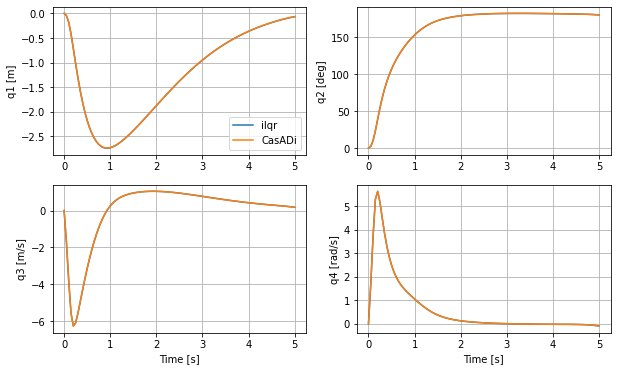

In [11]:

time = np.arange(N + 1) * dt

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0, 0].plot(time, X_opt_ilqr[:, 0], label='ilqr')
axs[0, 0].plot(time, X_opt_ca[0, :], label='CasADi')
axs[0, 0].set(ylabel='q1 [m]')
axs[0, 0].legend()
axs[0, 0].grid()

axs[0, 1].plot(time, np.rad2deg(X_opt_ilqr[: ,1]))
axs[0, 1].plot(time, np.rad2deg(X_opt_ca[1, :]))
axs[0, 1].set(ylabel='q2 [deg]')
axs[0, 1].grid()
 
axs[1, 0].plot(time, X_opt_ilqr[:, 2])
axs[1, 0].plot(time, X_opt_ca[2, :])
axs[1, 0].set(xlabel='Time [s]', ylabel='q3 [m/s]')
axs[1, 0].grid()

axs[1, 1].plot(time, X_opt_ilqr[:, 3])
axs[1, 1].plot(time, X_opt_ca[3, :])
axs[1, 1].set(xlabel='Time [s]', ylabel='q4 [rad/s]')
axs[1, 1].grid()

plt.show()

### Animation

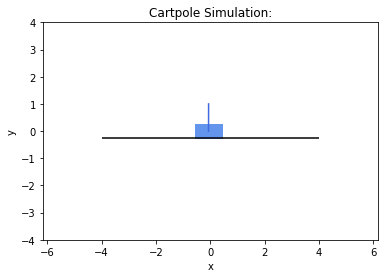

In [12]:
from visualization import visualize_cartpole
visualize_cartpole(X_opt_ilqr, dt=dt, L=1.)